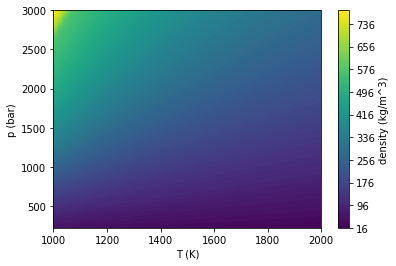

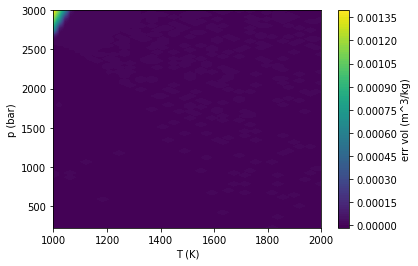

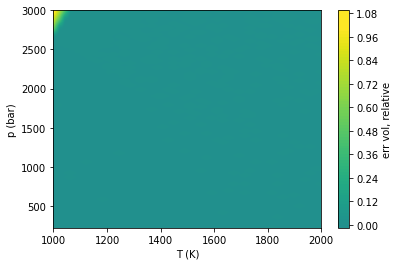

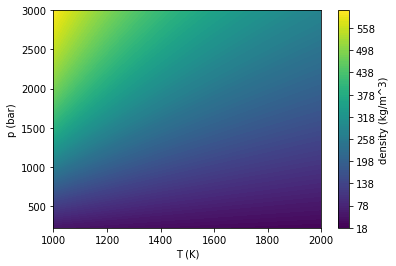

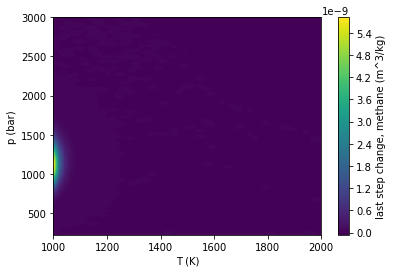

In [1]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Duan, M/oller, Weare (1995), Geoc. et Cosm. Acta

# Gas constant in local units
_R = 0.08314467
# LJ potential params
_eps   = 510    # K
_sigma = 2.88   # Angstrom
# Load Duan et al. data
_a = np.array([
      3.75504388e-02,
     -1.08730273e+04,
      1.10964861e+06,
      5.41589372e-04,
      1.12094559e+02,
     -5.92191393e+03,
      4.37200027e-06,
      4.95790731e-01,
     -1.64902948e+02,
     -7.07442825e-08,
      9.65727297e-03,
      4.87945175e-01,
      1.62257402e+04,
      8.99000000e-03,])
# IAPWS critical properties
_p_crit   = 22.064e1 # bar
_T_crit   = 647.096 # K
_rho_crit = 322     # kg/m3
_mol_weight = 18.015268e-3 # kg/mol

def compute_specvol(p, T, N_iter=10):
    ''' Returns specific volume in SI units (m3/kg). '''
    V_m_iters = np.array(list(batch_fpi(p, T, N_iter)))
    V_last_two = 1e-3 * V_m_iters[-2:,...] * (_sigma/3.691)**3 / _mol_weight
    # Return vol and error estimate
    return V_last_two[1,...], V_last_two[0,...] - V_last_two[1,...]

def batch_newton(p:np.array, T:np.array, N_iter:int):
    ''' Performs a vectorized fixed point iterateion over nd-arrays of P, T.
    Returns an iterable with the reference density (mapped to methane).
    '''
    # Set dummy values for accumulator list
    seed = list(range(N_iter))
    # Set initial guess in 0th element of accumulator list
    seed[0] = p / (_R * T)
    return itertools.accumulate(seed, lambda x, _:get_rhs(p, T)(x))

def rho_newton(p, T, rho_m=None, max_newton_iters=16, newton_abs_tol=1e-8):
    ''' Compute rho of water using Newton's method
    args
    p: pressure (bar)
    T: temperature (K)
    rho_m=None: initial guess for methane (reference fluid) density kg/m^3
    max_newton_iters
    newton_abs_tol
    '''
    if np.any(p < _p_crit):
        print("Pressure below crit pressure in bar")
    if np.any(T < _T_crit):
        print("Temperature below crit temperature in K")
    
    # Define dot product
    dot = lambda x, y: np.einsum("i, i... -> ...", x, y)
    # Reference values (map to supercritical methane)
    T_m = 154*T/_eps
    p_m = 3.0626*(_sigma**3)*p/_eps
    # Compute inverse temperature coeffs (1, 1/T_m**2, 1/T_m**3)
    T_vec = np.array([np.ones_like(T_m), 1/(T_m*T_m), 1/(T_m*T_m*T_m)])
    # Compute virial coefficients (1 to 5)
    v = np.array([
        dot(_a[0:3],T_vec),
        dot(_a[3:6],T_vec),
        0*dot(_a[3:6],T_vec),
        dot(_a[6:9],T_vec),
        dot(_a[9:12],T_vec),
    ])
    # Get enumeration coefficients (k+1)
    enum_coeffs = np.empty_like(v)
    enum_coeffs[:,...] = 1 + np.expand_dims(
        np.array(list(range(v.shape[0]))), axis=list(range(v.ndim))[1:])

    def nonmonomial(r2):
      ''' Compute nondimensional nonmonomial and its derivative '''
    #   # Define nonmonomial term as a function of rho_m**2 == r2
    #   nm = lambda r2: _a[12]*T_vec[2,...] * r2 * (1 + _a[13]*r2) \
    #        * np.exp(-_a[13]*r2)
    #   # Define derivative of nonmonomial term
    #   d_nm = lambda r2: _a[12]*T_vec[2,...] * r2 \
    #          * (3 + _a[13]*r2*(3 - 2*_a[13]*r2)) \
    #          * np.exp(-_a[13]*r2)
      prefactor = _a[12]*T_vec[2,...] * r2
      ar2 = _a[13]*r2
      expfactor = np.exp(-ar2)
      nm = prefactor * (1 + ar2) * expfactor
      d_nm = prefactor * (3 + ar2*(3 - 2*ar2)) * expfactor
      return nm, d_nm
    
    if rho_m is None:
      # Set default guess
      rho_m = np.ones_like(T_m)

    ''' Newton iteration '''
    for i in range(max_newton_iters):
        # Compute monomial values rho^k
        rp = np.ones((5,*np.array(T_m).shape))
        rp[:,...]= rho_m
        rp = np.cumprod(rp,axis=0)
        # Compute nonmonomial term
        nm, d_nm = nonmonomial(rho_m*rho_m)
        # Compute compressibility factor
        Z = 1 + np.einsum("i..., i... -> ...", v, rp) + nm
        # Compute target function F == 0
        F = rho_m * Z - p_m / (_R * T_m)
        # Compute function derivative dF
        dF = 1 + np.einsum("i..., i..., i... -> ...", v, rp, enum_coeffs) + d_nm
        # Compute next Newton iterate
        step = - F / dF
        rho_m += step
        if np.max(np.abs(step)) < newton_abs_tol:
            break
    num_iters = i
    # Compute water density from methane density
    rho = rho_m / (1e-3 * (_sigma/3.691)**3 / _mol_weight)
    # Return result and last Newton step in methane density
    return rho, step, rho_m, num_iters

''' FPI backend '''

def batch_fpi(p:np.array, T:np.array, N_iter:int):
    ''' Performs a vectorized fixed point iterateion over nd-arrays of P, T.
    Returns an iterable with the reference density (mapped to methane).
    '''
    # Set dummy values for accumulator list
    seed = list(range(N_iter))
    # Set initial guess in 0th element of accumulator list
    seed[0] = p / (_R * T)
    return itertools.accumulate(seed, lambda x, _:get_rhs(p, T)(x))

def get_rhs(p, T):
    ''' Returns RHS of the reference density equation.
    Returns RHS of Eqn. (1) in Duan et al., multiplied by R * T_m / P_m '''
    # Reference values (map to supercritical methane)
    T_m = 154*T/_eps
    p_m = 3.0626*(_sigma**3)*p/_eps
    # Return rhs: V_m == rhs(V_m)
    rhs = lambda V_m: (_R*T_m/p_m) * Z(T_m, V_m)
    return rhs

def Z(T_m, V_m):
    ''' Returns compressibility factor Z. '''
    # Compute inverse temperature coeffs (1, 1/T_m**2, 1/T_m**3)
    T_vec = np.array([np.ones_like(T_m), 1/(T_m*T_m), 1/(T_m*T_m*T_m)])
    # Define dot product
    dot = lambda x, y: np.einsum("i, i... -> ...", x, y)
    # Compute virial coefficients (1 to 5)
    v = np.array([
        dot(_a[0:3],T_vec),
        dot(_a[3:6],T_vec),
        0*dot(_a[3:6],T_vec),
        dot(_a[6:9],T_vec),
        dot(_a[9:12],T_vec),
    ])
    # Define nonmonomial term as a function of 1 / V_m**2 == r2
    nm = lambda r2: _a[12]*T_vec[2,...] * r2 * (1 + _a[13]*r2) \
         * np.exp(-_a[13]*r2)
    # Compute density
    r = 1 / V_m
    # Compute monomial values
    rp = np.ones((5,*np.array(T_m).shape))
    rp[:,...]= r
    rp = np.cumprod(rp,axis=0)
    return 1 + np.einsum("i..., i... -> ...", v, rp) + nm(r*r)
    # return np.polynomial.polynomial.Polynomial(v)(r) + nm(r*r)

def _test_fast(resolution_p=100,resolution_T=50):
    ''' One-line implementation tester. '''
    return np.array(list(batch_fpi(
        *np.meshgrid(np.linspace(1,10000,resolution_p),
                     np.linspace(400,2000,resolution_T)))))

def _test_plot(resolution_p=100,resolution_T=50):
    ''' Plot on some useful range of p, T. '''
    p, T = np.meshgrid(np.linspace(_p_crit,3000,resolution_p),
                       np.linspace(1000,2000,resolution_T))
    vol_m, err = compute_specvol(p, T, N_iter=50)

    plt.figure(1)
    plt.contourf(T, p, 1/vol_m, levels=100)
    plt.ylabel("p (bar)")
    plt.xlabel("T (K)")
    plt.colorbar(label="density (kg/m^3)")

    plt.figure(2)
    plt.contourf(T, p, err, levels=100)
    plt.ylabel("p (bar)")
    plt.xlabel("T (K)")
    plt.colorbar(label="err vol (m^3/kg)")

    plt.figure(3)
    plt.contourf(T, p, err/vol_m, levels=100)
    plt.ylabel("p (bar)")
    plt.xlabel("T (K)")
    plt.colorbar(label="err vol, relative")
    plt.clim((-1,1))

    return p, T, vol_m, err

def _test_plot_newton(resolution_p=100,resolution_T=50):
    ''' Plot on some useful range of p, T for Newton backend. '''
    p, T = np.meshgrid(np.linspace(_p_crit,3000,resolution_p),
                       np.linspace(1000,2000,resolution_T))
    rho, step, _, n_iter = rho_newton(p, T)

    plt.figure()
    plt.contourf(T, p, rho, levels=100)
    plt.ylabel("p (bar)")
    plt.xlabel("T (K)")
    plt.colorbar(label="density (kg/m^3)")

    plt.figure()
    plt.contourf(T, p, step, levels=100)
    plt.ylabel("p (bar)")
    plt.xlabel("T (K)")
    plt.colorbar(label="last step change, methane (m^3/kg)")

    return p, T, rho, step, n_iter

p, T, vol_m, err = _test_plot()
# p = 23*np.ones((7,1))
# T = 700*np.ones((7,1))
# rho_newton(p, T)
p, T, rho, step, n_iter = _test_plot_newton()

In [2]:
n_iter

13

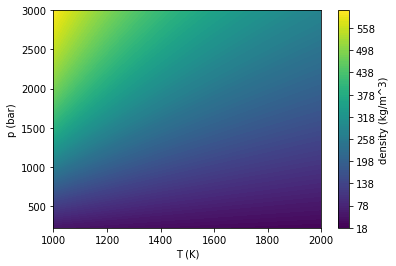

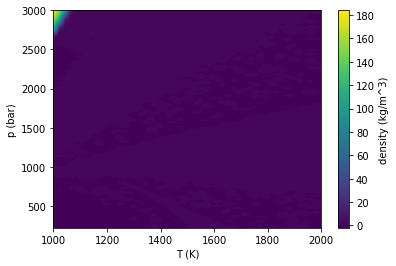

In [3]:
''' Brent refinement of FPI backend (use just for comparison to Newton). '''

vol_reduced = vol_m / (1e-3 * (_sigma/3.691)**3 / _mol_weight)

lower = 0.8*vol_reduced
upper = 1.8*vol_reduced
f = lambda v: get_rhs(p, T)(v) - v

from scipy.optimize import brentq

out = np.zeros_like(lower)
for (i,j), _ in np.ndenumerate(lower):
  out[i,j] = brentq(lambda v: get_rhs(p[i,j], T[i,j])(v) - v,
    lower[i,j], upper[i,j])


vol_refine = out*(1e-3 * (_sigma/3.691)**3 / _mol_weight)
plt.figure(1)
plt.contourf(T, p, 1/vol_refine, levels=100)
plt.ylabel("p (bar)")
plt.xlabel("T (K)")
plt.colorbar(label="density (kg/m^3)")

plt.figure(2)
plt.contourf(T, p, 1/vol_m - 1/vol_refine, levels=100)
plt.ylabel("p (bar)")
plt.xlabel("T (K)")
plt.colorbar(label="density (kg/m^3)")

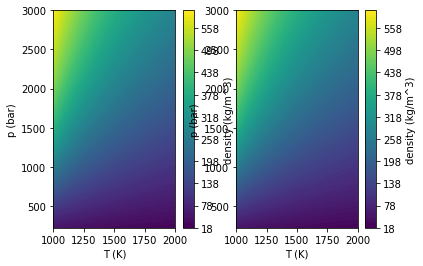

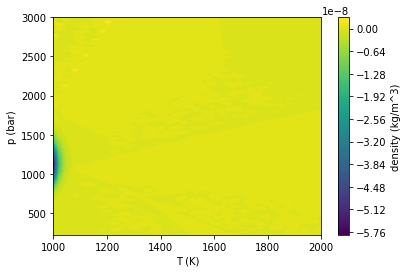

In [4]:
plt.subplot(1,2,1)
plt.contourf(T, p, 1/vol_refine, levels=100)
plt.ylabel("p (bar)")
plt.xlabel("T (K)")
plt.colorbar(label="density (kg/m^3)")

plt.subplot(1,2,2)
plt.contourf(T, p, rho, levels=100)
plt.ylabel("p (bar)")
plt.xlabel("T (K)")
plt.colorbar(label="density (kg/m^3)")

plt.figure()
plt.contourf(T, p, rho - 1/vol_refine, levels=100)
plt.ylabel("p (bar)")
plt.xlabel("T (K)")
plt.colorbar(label="density (kg/m^3)")

In [52]:
from pyXSteam.XSteam import XSteam
xsteam = XSteam(XSteam.UNIT_SYSTEM_BARE)
p_subcrit, T_subcrit = np.meshgrid(np.linspace(0.1, _p_crit, 100),
  np.linspace(500,2000,100))
rho_xsteam = np.empty_like(p_subcrit)
for (i, j), _ in np.ndenumerate(p_subcrit):
  rho_xsteam[i,j] = xsteam.rho_pt(1e-1*p_subcrit[i,j], T_subcrit[i,j])

p_coldhigh, T_coldhigh = np.meshgrid(np.linspace(_p_crit, 1e1*100, 100),
  np.linspace(500,1000,100))
rho_xsteam_coldhigh = np.empty_like(p_coldhigh)
for (i, j), _ in np.ndenumerate(p_coldhigh):
  rho_xsteam_coldhigh[i,j] = xsteam.rho_pt(1e-1*p_coldhigh[i,j], T_coldhigh[i,j])

In [ ]:
# Horizontal boundary
hz_T = T_subcrit[33:,-1]
hz_p = p_subcrit[33:,-1]

# Vertical boundary
vt_T = T_coldhigh[-1,:]
vt_p = p_coldhigh[-1,:]

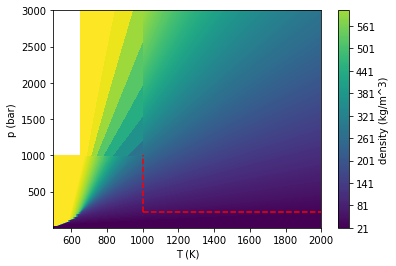

In [105]:
caxis = (20,700)

plt.clf()
plt.contourf(T_subcrit, p_subcrit, rho_xsteam, levels=200)
plt.ylabel("p (bar)")
plt.xlabel("T (K)")
plt.clim(caxis)

plt.contourf(T_coldhigh, p_coldhigh, rho_xsteam_coldhigh, levels=200)
plt.ylabel("p (bar)")
plt.xlabel("T (K)")
plt.clim(caxis)

# plt.figure()
plt.contourf(T, p, rho, levels=200)
plt.ylabel("p (bar)")
plt.xlabel("T (K)")
plt.clim(caxis)

cb = plt.colorbar(label="density (kg/m^3)")

# Plot boundaries
plt.plot(hz_T, hz_p, 'r--')
plt.plot(vt_T, vt_p, 'r--')
# Plot supercrits
plt.plot(_T_crit*np.array([1,1]), np.array([1,500]))

# Plot high uncertainty region
pcold2, Tcold2 = np.meshgrid(np.linspace(1000, 3000, 100),
  np.linspace(650,1000,100))
rhocold2 = rho_newton(pcold2, Tcold2, max_newton_iters=32, newton_abs_tol=1e-7)[0]
plt.contourf(Tcold2, pcold2, rhocold2, levels=10)
plt.clim(caxis)



In [114]:
xsteam.rho_pt(50, 1073)

110.22665297776025

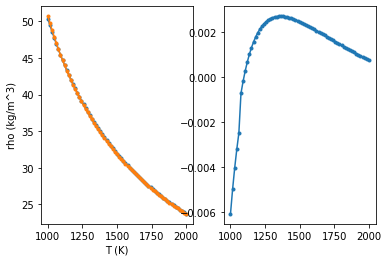

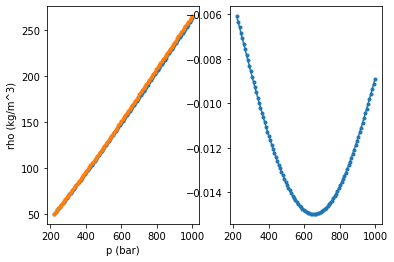

In [83]:
# Plot boundary values

# Horizontal boundary
hz_T = T_subcrit[33:,-1]
hz_p = p_subcrit[33:,-1]

# Vertical boundary
vt_T = T_coldhigh[-1,:]
vt_p = p_coldhigh[-1,:]

# Compute density from Duan et al. supercritical model
hz_rho = rho_newton(hz_p, hz_T, rho_m=None, max_newton_iters=16, newton_abs_tol=1e-6)[0]
vt_rho = rho_newton(vt_p, vt_T, rho_m=None, max_newton_iters=16, newton_abs_tol=1e-6)[0]
plt.subplot(1,2,1)
plt.plot(hz_T, hz_rho, '.-')
plt.plot(hz_T, rho_xsteam[33:,-1], '.-')
plt.xlabel("T (K)")
plt.ylabel("rho (kg/m^3)")
plt.subplot(1,2,2)
plt.plot(hz_T, hz_rho/rho_xsteam[33:,-1] - 1, '.-')

plt.figure()
plt.subplot(1,2,1)
plt.plot(vt_p, vt_rho, '.-')
plt.plot(vt_p, rho_xsteam_coldhigh[-1,:], '.-')
plt.xlabel("p (bar)")
plt.ylabel("rho (kg/m^3)")
plt.subplot(1,2,2)
plt.plot(vt_p, vt_rho/rho_xsteam_coldhigh[-1,:] - 1, '.-')